# Changes:

1. Use resnet as backbone encoder
2. use deeplab v3+ architecture

## Install required packages if running on google colab

In [1]:
try:
    import torch
except:
    !pip install torch torchvision
    !pip install imageio
    !pip install Augmentor
    !git clone https://github.com/allen-q/salt_oil.git
    !git clone https://github.com/allen-q/salt_net.git

In [2]:
cd salt_oil/

[WinError 2] The system cannot find the file specified: 'salt_oil/'
C:\work\code\repos\salt_oil


## Import required libs

In [3]:
import zipfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
import os
import imageio
from PIL import Image
import glob
import matplotlib.pyplot as plt
import time
import math
import datetime as dt
import pytz
import pickle
from salt_func_lib import *
from torchvision import transforms, utils
from skimage import io, transform
import datetime as dt
import sys
from optparse import OptionParser
import torch.backends.cudnn as cudnn
from torch import optim
from torch.optim import lr_scheduler
import copy
from io import BytesIO
import Augmentor
import random
import PIL
% matplotlib inline
% load_ext autoreload
% autoreload 2

## Load Unet Modules

In [4]:
from pytorch_unet.eval import eval_net
from pytorch_unet.unet import UNet
from pytorch_unet.unet.unet_parts import *
from pytorch_unet.utils import get_ids, split_ids, split_train_val, get_imgs_and_masks, batch
from pytorch_unet.unet.resnet import *

In [5]:
## Setup data type based on whether GPU is enabled

In [6]:
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!
else:    
    dtype = torch.FloatTensor

In [7]:
print(f'Data Type set to: {dtype}')

Data Type set to: <class 'torch.FloatTensor'>


## Create Global Variables

In [8]:
def init_global_variables():
    """initialize global variables such as db connection, logger etc."""
    global log
    log = get_logger('SaltNet')

In [9]:
init_global_variables()

In [10]:
class SaltDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, np_img, np_mask, df_depth, mean_img, out_size=101, out_ch=1, transform=None):
        """
        Args:
            data_dir (string): Path to the image files.
            train (bool): Load train or test data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.np_img = np_img
        self.np_mask = np_mask.clip(0,1)
        self.df_depth = df_depth
        self.mean_img = mean_img
        self.out_size = out_size
        self.out_ch = out_ch
        self.transform = transform

    def __len__(self):
        return len(self.np_img)

    def __getitem__(self, idx):

        X_orig = self.np_img[idx]
        #X = X_orig - self.mean_img

        if self.np_mask is None:
            y = np.zeros((101,101,1))
        else:
            y = self.np_mask[idx]

        if self.transform:
            img_in = PIL.Image.fromarray(np.c_[np.tile(X_orig, 2), y*255])
            #img_in = PIL.Image.fromarray(np.tile(y, 3)*255)
            transformed = np.array(self.transform(img_in))
            X = np.clip(transformed[:,:,0:1]/255, 0., 1.) - self.mean_img
            y = np.clip(transformed[:,:,2:3]/255, 0., 1.)
        else:
            X = np.clip(X_orig/255, 0., 1.) - self.mean_img

        #print(X.dtype)
        
        X = np.moveaxis(X, -1,0)

        pad_size = self.out_size - X.shape[2]
        pad_first = pad_size//2
        pad_last = pad_size - pad_first
        X = np.pad(X, [(0, 0),(pad_first, pad_last), (pad_first, pad_last)], mode='reflect')
        #print(X.dtype)

        d = self.df_depth.iloc[idx,0]
        #id = self.df_depth.index[idx]
        #from boxx import g
        #g()
        X = torch.from_numpy(X).float().type(dtype)
        X = X.repeat(self.out_ch,1,1)
        y = transform.resize(y, (101, 101), mode='constant', preserve_range=True)
        y = torch.from_numpy(y).float().squeeze().type(dtype)

        return (X,y,d,idx)

In [11]:
class Pipeline_Salt(Augmentor.Pipeline):
    def __init__(self, source_directory=None, output_directory="output", save_format=None):
        super(Pipeline_Salt, self).__init__(source_directory, output_directory, save_format)

    def torch_transform(self):
        """
        Returns the pipeline as a function that can be used with torchvision.

        .. code-block:: python

            >>> import Augmentor
            >>> import torchvision
            >>> p = Augmentor.Pipeline()
            >>> p.rotate(probability=0.7, max_left_rotate=10, max_right_rotate=10)
            >>> p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
            >>> transforms = torchvision.transforms.Compose([
            >>>     p.torch_transform(),
            >>>     torchvision.transforms.ToTensor(),
            >>> ])

        :return: The pipeline as a function.
        """
        def _transform(image):
            for operation in self.operations:
                r = round(random.uniform(0, 1), 1)
                if r <= operation.probability:
                    if not isinstance(image, list):
                        image = [image]
                    image = operation.perform_operation(image)[0]

            return image

        return _transform

## Prepare Data

### Load train and test data from npy files or from raw images if npy files not exist.

In [12]:
np_train_all, np_train_all_mask, X_test, misc_data = load_all_data()

Try loading data from npy and pickle files...
Data loaded.


### Remove black images

In [13]:
#black_img_ids = (np_train_all.max((1,2,3))==0)

#np_train_all = np_train_all[~black_img_ids]
#np_train_all_mask = np_train_all_mask[~black_img_ids]

In [14]:
np_train_all.shape

(4000, 101, 101, 1)

### Remove images with all black masks

In [15]:
#black_mask_ids = (np_train_all_mask.max((1,2,3))==0)
#np_train_all = np_train_all[~black_mask_ids]
#np_train_all_mask = np_train_all_mask[~black_mask_ids]

In [16]:
np_train_all_mask.shape

(4000, 101, 101, 1)

### Train Val data split

In [17]:
#np_train_all = np.clip(np_train_all/255, 0, 1)
#X_test = np.clip(X_test/255, 0, 1)

In [18]:
np_train_all.shape

(4000, 101, 101, 1)

In [19]:
X_train_ids, X_val_ids = (
    train_test_split(np.arange(len(np_train_all)), 
                     test_size=0.20, 
                     random_state=42)
)

In [20]:
X_train = np_train_all[X_train_ids]
X_val = np_train_all[X_val_ids]
y_train = np_train_all_mask[X_train_ids]
y_val = np_train_all_mask[X_val_ids]

#salt_pix_sum = (y_train/255).sum((1,2,3))
#low_salt_img_masks = (salt_pix_sum>0) & (salt_pix_sum<154)
#X_train = X_train[~low_salt_img_masks]
#y_train = y_train[~low_salt_img_masks]


depth_train = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_train_ids])
    #.loc[~low_salt_img_masks]
)
depth_val = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_val_ids])
)
depth_test = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_test_ids']))
)
#X_train_mean_img = X_train.mean(0).astype(np.float32)
#X_train_mean_img = X_train.mean((0,1,2)).astype(np.float32)
X_train_mean_img = np.clip(np_train_all/255, 0, 1).mean((0,1,2)).astype(np.float32)

all_data = {
    'X_train': X_train,
    'X_val': X_val,
    'y_train': y_train,
    'y_val': y_val,
    'X_test': X_test,
    'X_train_mean_img': X_train_mean_img
}

### Remove images with low salt percent (<1.5%)

In [21]:
depth_train.shape

(3200, 1)

In [22]:
X_train.shape

(3200, 101, 101, 1)

In [23]:
y_train.shape

(3200, 101, 101, 1)

In [24]:
X_val.shape

(800, 101, 101, 1)

In [25]:
p = Pipeline_Salt()
#p.skew(probability=1, magnitude=0.5)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=5)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.0, max_factor=1.2)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)
p.crop_by_size(probability=0.5, width=101, height=101, centre=False)


### Create a Train Dataloader

In [26]:
'''composed_tsfm = transforms.Compose([Rescale(scale='random', min_scale=1, max_scale=2),
                                    RandomCrop(101),
                                    Flip(orient='random')])'''

data_params = {'batch_size': 32,
               'shuffle': True,
               'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           X_train_mean_img, out_size=128,  out_ch=1,
                           transform=p.torch_transform()), **data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           X_train_mean_img, out_size=128, out_ch=1), **data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

sample = iter(dataloaders['train']).__next__()

assert sample[0].shape == torch.Size([data_params['batch_size'], 1, 128, 128])
assert sample[1].shape == torch.Size([data_params['batch_size'], 101, 101])
assert sample[2].shape == torch.Size([data_params['batch_size']])
assert sample[3].shape == torch.Size([data_params['batch_size']])

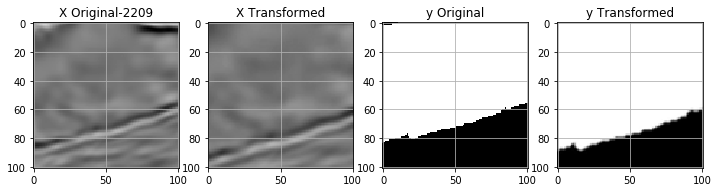

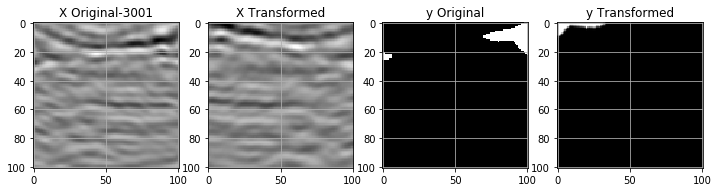

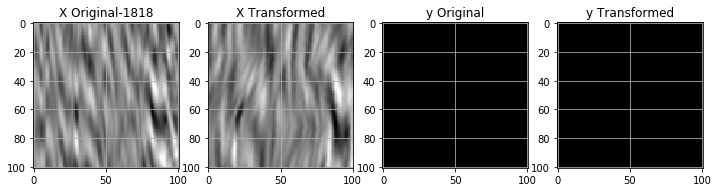

In [27]:
i = 0
for X_batch, y_batch, d_batch, X_id in dataloaders['train']:
    i+=1
    if i>3:
        break
    X_orig = X_train[X_id[0]].squeeze()/255
    X_tsfm = X_batch[0,0].squeeze().cpu().detach().numpy()[13:114,13:114] + X_train_mean_img.squeeze()
    y_orig = y_train[X_id[0]].squeeze()
    y_tsfm = (y_batch[0].squeeze().cpu().detach().numpy())
    plot_img_mask_pred([X_orig, X_tsfm, y_orig, y_tsfm],
                       [f'X Original-{X_id[0]}', 'X Transformed', 'y Original', 'y Transformed'])

In [28]:
X_train.shape

(3200, 101, 101, 1)

### Create a Train Dataloader for sanity check

In [29]:
data_params = {'batch_size': 4,
               'shuffle': False,
               'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train[:8], y_train[:8], depth_train[:8],
                           X_train_mean_img, out_size=128, out_ch=1,
                           transform=None), **data_params)
                           #transform=p.torch_transform()), **data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val[:8], y_val[:8], depth_val[:8], 
                           X_train_mean_img, out_size=128, out_ch=1), **data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}


In [30]:
t = iter(train_dataLoader).__next__()

In [31]:
X_batch, y_batch, d_batch, X_id = t

In [34]:
def train_model(model, dataloaders, criterion1, criterion2, optimizer, scheduler, model_save_name, other_data={}, 
                num_epochs=25, print_every=2, save_model_every=None, save_log_every=None, log=get_logger('SaltNet'), loss2_weight=0):
    #args = locals()
    #args = {k:v.shape if isinstance(v, (torch.Tensor, np.ndarray)) else v for k,v in args.items()}
    #args = {k:v.shape if isinstance(v, (torch.Tensor, np.ndarray)) else v for k,v in args.items()}
    log.info('Start Training...')
    #log.info('Passed parameters: {}'.format(args))

    start = time.time()

    if torch.cuda.is_available():
        model.cuda()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_model = None
    best_iou = 0.0
    all_losses = []
    iter_count = 0
    X_train = other_data['X_train']
    X_val = other_data['X_val']
    y_train = other_data['y_train']
    y_val = other_data['y_val']
    X_train_mean_img = other_data['X_train_mean_img']
    mask_cutoff = 0.

    for epoch in range(1, num_epochs+1):
        log.info('Epoch {}/{}'.format(epoch, num_epochs))
        log.info('-' * 20)
        if save_log_every is not None:
            if (epoch % save_log_every == 0):
                push_log_to_git()
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_loss1 = []
            epoch_loss2 = []
            pred_vs_true_epoch = []

            for X_batch, y_batch, d_batch, X_id in dataloaders[phase]:
                # zero the parameter gradients
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    #y_pred, y_mask_pred = model(X_batch)
                    y_pred = model(X_batch)
                    pred_vs_true_epoch.append([y_pred, y_batch])
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':                        
                        #from boxx import g
                        #g()
                        loss_1 = criterion1(y_pred, y_batch.float())      
                        loss_2 = loss2_weight * criterion2(y_pred, y_batch.float()) 

                        #print(f'loss_pix: {loss_pix}, loss_dice:{loss_dice}')
                        loss = loss_1 + loss_2
                        #loss = loss_pix
                        all_losses.append(loss.item())
                        epoch_loss1.append(loss_1.item())
                        epoch_loss2.append(loss_2.item())
                        
                        loss.backward()
                        optimizer.step()
                        iter_count += 1
                if (phase == 'train') & (iter_count % print_every == 0):
                    iou_batch = calc_mean_iou(y_pred.ge(mask_cutoff), y_batch.float())
                    iou_acc = calc_clf_accuracy(y_pred.ge(mask_cutoff), y_batch.float())

                    log.info('Batch Loss: {:.4f}, Epoch loss_1: {:.4f}, Epoch loss_2: {:.4f}, Batch IOU: {:.4f}, Batch Acc: {:.4f} at iter {}, epoch {}, Time: {}'.format(
                        np.mean(all_losses[-print_every:]), np.mean(epoch_loss1), np.mean(epoch_loss2), iou_batch, iou_acc, iter_count, epoch, timeSince(start))
                    )
                    #print(all_losses)
                    X_orig = X_train[X_id[0]].squeeze()/255
                    X_tsfm = X_batch[0,0].squeeze().cpu().detach().numpy()
                    X_tsfm = transform.resize(X_tsfm, (128, 128), mode='constant', preserve_range=True)
                    X_tsfm = X_tsfm[13:114,13:114] + X_train_mean_img.squeeze()
                    #X_tsfm = X_batch[0][X_batch[0].sum((1,2)).argmax()].squeeze().cpu().detach().numpy()[:101,:101] + X_train_mean_img.squeeze()

                    y_orig = y_train[X_id[0]].squeeze()
                    y_tsfm = (y_batch[0].squeeze().cpu().detach().numpy())
                    y_tsfm_pred =  y_pred[0].squeeze().gt(mask_cutoff)
                    plot_img_mask_pred([X_orig, X_tsfm, y_orig, y_tsfm, y_tsfm_pred],
                                       ['X Original', 'X Transformed', 'y Original', 'y Transformed', 'y Predicted'])

            y_pred_epoch = torch.cat([e[0] for e in pred_vs_true_epoch])
            y_true_epoch = torch.cat([e[1] for e in pred_vs_true_epoch])
            #from boxx import g
            #g()
            mean_iou_epoch = calc_mean_iou(y_pred_epoch.ge(mask_cutoff), y_true_epoch.float())
            mean_acc_epoch = calc_clf_accuracy(y_pred_epoch.ge(mask_cutoff), y_true_epoch.float())
            log.info('{} Mean IOU: {:.4f}, Mean Acc: {:.4f}, Best Val IOU: {:.4f} at epoch {}'.format(phase, mean_iou_epoch, mean_acc_epoch, best_iou, epoch))
            if phase == 'val' and mean_iou_epoch > best_iou:
                best_iou = mean_iou_epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                stats = {'best_iou': best_iou,
                         'all_losses': all_losses,
                         'iter_count': iter_count}
                log.info(save_model_state_to_chunks(epoch, copy.deepcopy(model.state_dict()),
                                                    copy.deepcopy(optimizer.state_dict()),
                                                    copy.deepcopy(scheduler.state_dict()), stats, model_save_name, '.'))
                best_model = (epoch, copy.deepcopy(model.state_dict()),
                                                    copy.deepcopy(optimizer.state_dict()),
                                                    copy.deepcopy(scheduler.state_dict()), stats, model_save_name, '.')
                log.info('Best Val Mean IOU so far: {}'.format(best_iou))
                # Visualize 1 val sample and predictions
                X_orig = X_val[X_id[0]].squeeze()/255
                y_orig = y_val[X_id[0]].squeeze()
                y_pred2 =  y_pred[0].squeeze().gt(mask_cutoff)
                plot_img_mask_pred([X_orig, y_orig, y_pred2],
                                   ['Val X Original', 'Val y Original', 'Val y Predicted'])
        if save_model_every is not None:
            if (epoch % save_model_every == 0) | (epoch == num_epochs-1):
                if (best_model is not None) and (best_iou>0.81):
                    log.info(save_model_state_to_chunks(*best_model))                
                    push_model_to_git(ckp_name=model_save_name)
                    best_model = None
                else:
                    log.info("Skip pushing model to git as there's no improvement")

    # load best model weights
    model.load_state_dict(best_model_wts)
    log.info('-' * 20)
    time_elapsed = time.time() - start
    log.info('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    log.info('Best val IOU: {:4f}'.format(best_iou))

    return model

## Train the model using a small data set to see if it can overfit

In [35]:
saltnet = resnet34unet()

Local ResNet


08/09/2018 15:15:22 - SaltNet - INFO - Start Training...
08/09/2018 15:15:22 - SaltNet - INFO - Epoch 1/100
08/09/2018 15:15:22 - SaltNet - INFO - --------------------
08/09/2018 15:15:31 - SaltNet - INFO - Batch Loss: 11.2324, Epoch loss_1: 11.2324, Epoch loss_2: 0.0000, Batch IOU: 0.0000, Batch Acc: 0.5180 at iter 2, epoch 1, Time: 0m 9s


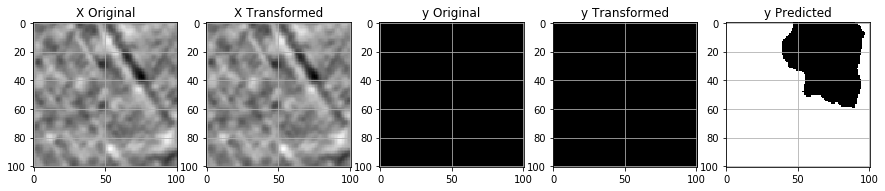

08/09/2018 15:15:32 - SaltNet - INFO - train Mean IOU: 0.0000, Mean Acc: 0.5262, Best Val IOU: 0.0000 at epoch 1
08/09/2018 15:15:34 - SaltNet - INFO - val Mean IOU: 0.2375, Mean Acc: 0.4171, Best Val IOU: 0.0000 at epoch 1
08/09/2018 15:15:35 - SaltNet - INFO - Model state is not saved as the out_file_prefix is None
08/09/2018 15:15:35 - SaltNet - INFO - Best Val Mean IOU so far: 0.2375


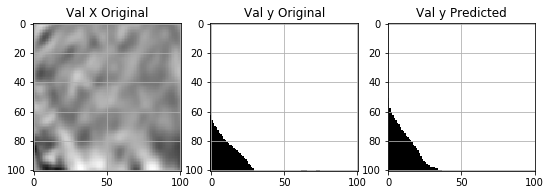

08/09/2018 15:15:35 - SaltNet - INFO - Epoch 2/100
08/09/2018 15:15:35 - SaltNet - INFO - --------------------
08/09/2018 15:15:46 - SaltNet - INFO - Batch Loss: 15.4415, Epoch loss_1: 15.4415, Epoch loss_2: 0.0000, Batch IOU: 0.0000, Batch Acc: 0.6178 at iter 4, epoch 2, Time: 0m 24s


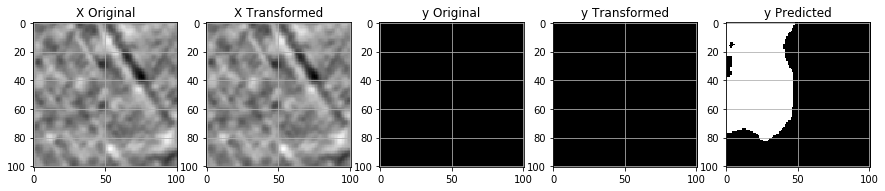

08/09/2018 15:15:47 - SaltNet - INFO - train Mean IOU: 0.0000, Mean Acc: 0.6029, Best Val IOU: 0.2375 at epoch 2
08/09/2018 15:15:49 - SaltNet - INFO - val Mean IOU: 0.1750, Mean Acc: 0.3969, Best Val IOU: 0.2375 at epoch 2
08/09/2018 15:15:49 - SaltNet - INFO - Epoch 3/100
08/09/2018 15:15:49 - SaltNet - INFO - --------------------
08/09/2018 15:15:59 - SaltNet - INFO - Batch Loss: 5.2646, Epoch loss_1: 5.2646, Epoch loss_2: 0.0000, Batch IOU: 0.0250, Batch Acc: 0.8431 at iter 6, epoch 3, Time: 0m 37s


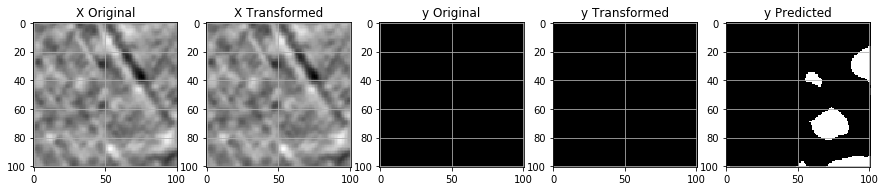

08/09/2018 15:16:00 - SaltNet - INFO - train Mean IOU: 0.0125, Mean Acc: 0.7075, Best Val IOU: 0.2375 at epoch 3
08/09/2018 15:16:03 - SaltNet - INFO - val Mean IOU: 0.0000, Mean Acc: 0.6122, Best Val IOU: 0.2375 at epoch 3
08/09/2018 15:16:03 - SaltNet - INFO - Epoch 4/100
08/09/2018 15:16:03 - SaltNet - INFO - --------------------
08/09/2018 15:16:11 - SaltNet - INFO - Batch Loss: 1.0606, Epoch loss_1: 1.0606, Epoch loss_2: 0.0000, Batch IOU: 0.0000, Batch Acc: 0.9156 at iter 8, epoch 4, Time: 0m 49s


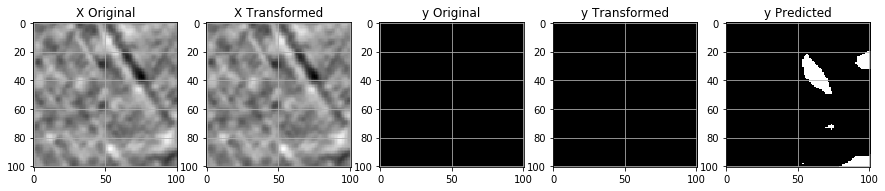

08/09/2018 15:16:12 - SaltNet - INFO - train Mean IOU: 0.0500, Mean Acc: 0.8618, Best Val IOU: 0.2375 at epoch 4
08/09/2018 15:16:14 - SaltNet - INFO - val Mean IOU: 0.0125, Mean Acc: 0.5429, Best Val IOU: 0.2375 at epoch 4
08/09/2018 15:16:14 - SaltNet - INFO - Epoch 5/100
08/09/2018 15:16:14 - SaltNet - INFO - --------------------
08/09/2018 15:16:25 - SaltNet - INFO - Batch Loss: 0.8084, Epoch loss_1: 0.8084, Epoch loss_2: 0.0000, Batch IOU: 0.2500, Batch Acc: 0.8874 at iter 10, epoch 5, Time: 1m 3s


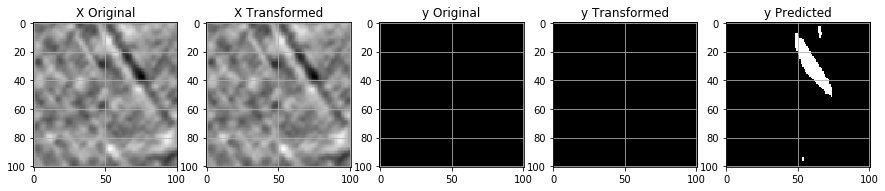

08/09/2018 15:16:26 - SaltNet - INFO - train Mean IOU: 0.2750, Mean Acc: 0.8980, Best Val IOU: 0.2375 at epoch 5
08/09/2018 15:16:28 - SaltNet - INFO - val Mean IOU: 0.1250, Mean Acc: 0.5242, Best Val IOU: 0.2375 at epoch 5
08/09/2018 15:16:28 - SaltNet - INFO - Epoch 6/100
08/09/2018 15:16:28 - SaltNet - INFO - --------------------
08/09/2018 15:16:37 - SaltNet - INFO - Batch Loss: 0.6309, Epoch loss_1: 0.6309, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.8843 at iter 12, epoch 6, Time: 1m 15s


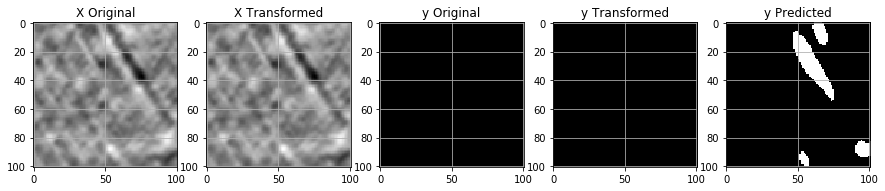

08/09/2018 15:16:38 - SaltNet - INFO - train Mean IOU: 0.4250, Mean Acc: 0.9025, Best Val IOU: 0.2375 at epoch 6
08/09/2018 15:16:40 - SaltNet - INFO - val Mean IOU: 0.1750, Mean Acc: 0.4883, Best Val IOU: 0.2375 at epoch 6
08/09/2018 15:16:40 - SaltNet - INFO - Epoch 7/100
08/09/2018 15:16:40 - SaltNet - INFO - --------------------
08/09/2018 15:16:51 - SaltNet - INFO - Batch Loss: 0.4550, Epoch loss_1: 0.4550, Epoch loss_2: 0.0000, Batch IOU: 0.2500, Batch Acc: 0.9084 at iter 14, epoch 7, Time: 1m 29s


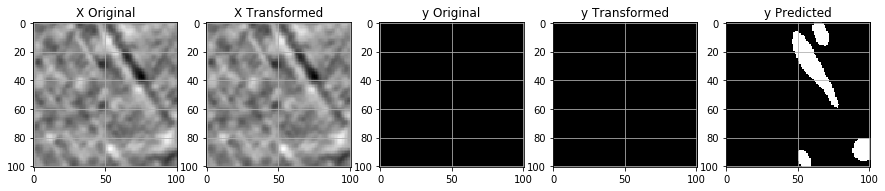

08/09/2018 15:16:52 - SaltNet - INFO - train Mean IOU: 0.3625, Mean Acc: 0.9278, Best Val IOU: 0.2375 at epoch 7
08/09/2018 15:16:55 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.3873, Best Val IOU: 0.2375 at epoch 7
08/09/2018 15:16:56 - SaltNet - INFO - Model state is not saved as the out_file_prefix is None
08/09/2018 15:16:56 - SaltNet - INFO - Best Val Mean IOU so far: 0.25


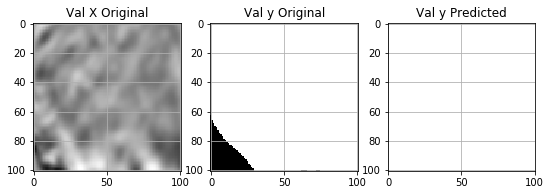

08/09/2018 15:16:57 - SaltNet - INFO - Epoch 8/100
08/09/2018 15:16:57 - SaltNet - INFO - --------------------
08/09/2018 15:17:09 - SaltNet - INFO - Batch Loss: 0.3561, Epoch loss_1: 0.3561, Epoch loss_2: 0.0000, Batch IOU: 0.3750, Batch Acc: 0.9463 at iter 16, epoch 8, Time: 1m 47s


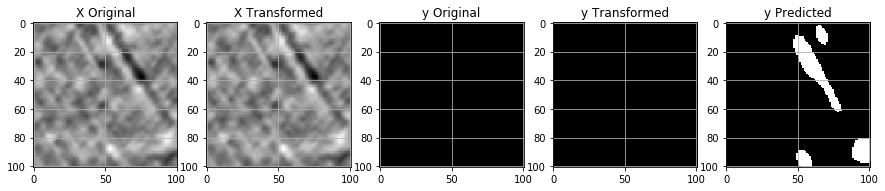

08/09/2018 15:17:10 - SaltNet - INFO - train Mean IOU: 0.4375, Mean Acc: 0.9493, Best Val IOU: 0.2500 at epoch 8
08/09/2018 15:17:12 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.3873, Best Val IOU: 0.2500 at epoch 8
08/09/2018 15:17:12 - SaltNet - INFO - Epoch 9/100
08/09/2018 15:17:12 - SaltNet - INFO - --------------------
08/09/2018 15:17:24 - SaltNet - INFO - Batch Loss: 0.2843, Epoch loss_1: 0.2843, Epoch loss_2: 0.0000, Batch IOU: 0.3750, Batch Acc: 0.9541 at iter 18, epoch 9, Time: 2m 1s


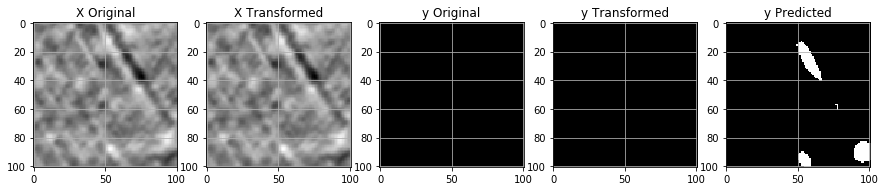

08/09/2018 15:17:24 - SaltNet - INFO - train Mean IOU: 0.4250, Mean Acc: 0.9533, Best Val IOU: 0.2500 at epoch 9
08/09/2018 15:17:27 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.3873, Best Val IOU: 0.2500 at epoch 9
08/09/2018 15:17:27 - SaltNet - INFO - Epoch 10/100
08/09/2018 15:17:27 - SaltNet - INFO - --------------------
08/09/2018 15:17:39 - SaltNet - INFO - Batch Loss: 0.2278, Epoch loss_1: 0.2278, Epoch loss_2: 0.0000, Batch IOU: 0.1500, Batch Acc: 0.9657 at iter 20, epoch 10, Time: 2m 16s


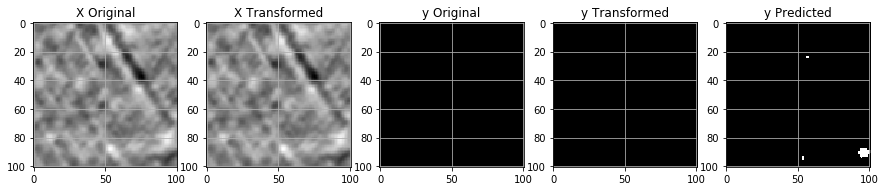

08/09/2018 15:17:39 - SaltNet - INFO - train Mean IOU: 0.3125, Mean Acc: 0.9603, Best Val IOU: 0.2500 at epoch 10
08/09/2018 15:17:42 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.3873, Best Val IOU: 0.2500 at epoch 10
08/09/2018 15:17:42 - SaltNet - INFO - Epoch 11/100
08/09/2018 15:17:42 - SaltNet - INFO - --------------------
08/09/2018 15:17:54 - SaltNet - INFO - Batch Loss: 0.1920, Epoch loss_1: 0.1920, Epoch loss_2: 0.0000, Batch IOU: 0.4000, Batch Acc: 0.9679 at iter 22, epoch 11, Time: 2m 31s


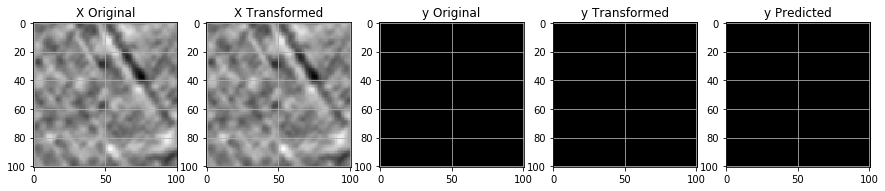

08/09/2018 15:17:54 - SaltNet - INFO - train Mean IOU: 0.4250, Mean Acc: 0.9601, Best Val IOU: 0.2500 at epoch 11
08/09/2018 15:17:57 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.3873, Best Val IOU: 0.2500 at epoch 11
08/09/2018 15:17:57 - SaltNet - INFO - Epoch 12/100
08/09/2018 15:17:57 - SaltNet - INFO - --------------------
08/09/2018 15:18:07 - SaltNet - INFO - Batch Loss: 0.1753, Epoch loss_1: 0.1753, Epoch loss_2: 0.0000, Batch IOU: 0.4250, Batch Acc: 0.9671 at iter 24, epoch 12, Time: 2m 45s


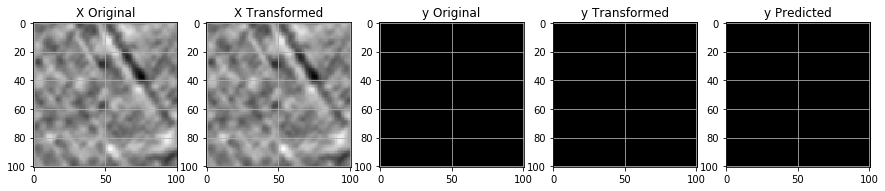

08/09/2018 15:18:08 - SaltNet - INFO - train Mean IOU: 0.4375, Mean Acc: 0.9581, Best Val IOU: 0.2500 at epoch 12
08/09/2018 15:18:11 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.3873, Best Val IOU: 0.2500 at epoch 12
08/09/2018 15:18:11 - SaltNet - INFO - Epoch 13/100
08/09/2018 15:18:11 - SaltNet - INFO - --------------------
08/09/2018 15:18:23 - SaltNet - INFO - Batch Loss: 0.1572, Epoch loss_1: 0.1572, Epoch loss_2: 0.0000, Batch IOU: 0.4250, Batch Acc: 0.9668 at iter 26, epoch 13, Time: 3m 0s


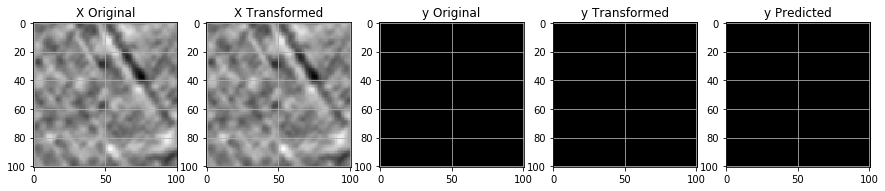

08/09/2018 15:18:24 - SaltNet - INFO - train Mean IOU: 0.4375, Mean Acc: 0.9576, Best Val IOU: 0.2500 at epoch 13
08/09/2018 15:18:26 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.3873, Best Val IOU: 0.2500 at epoch 13
08/09/2018 15:18:26 - SaltNet - INFO - Epoch 14/100
08/09/2018 15:18:26 - SaltNet - INFO - --------------------
08/09/2018 15:18:35 - SaltNet - INFO - Batch Loss: 0.1297, Epoch loss_1: 0.1297, Epoch loss_2: 0.0000, Batch IOU: 0.6750, Batch Acc: 0.9710 at iter 28, epoch 14, Time: 3m 13s


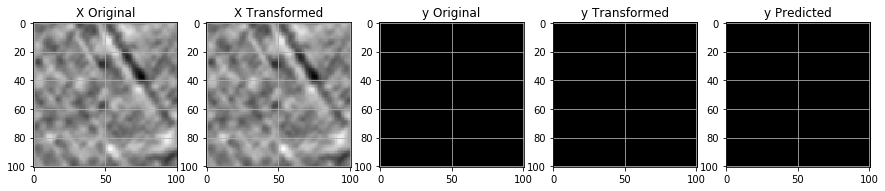

08/09/2018 15:18:36 - SaltNet - INFO - train Mean IOU: 0.5625, Mean Acc: 0.9620, Best Val IOU: 0.2500 at epoch 14
08/09/2018 15:18:38 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.3873, Best Val IOU: 0.2500 at epoch 14
08/09/2018 15:18:38 - SaltNet - INFO - Epoch 15/100
08/09/2018 15:18:38 - SaltNet - INFO - --------------------
08/09/2018 15:18:48 - SaltNet - INFO - Batch Loss: 0.1085, Epoch loss_1: 0.1085, Epoch loss_2: 0.0000, Batch IOU: 0.6750, Batch Acc: 0.9791 at iter 30, epoch 15, Time: 3m 26s


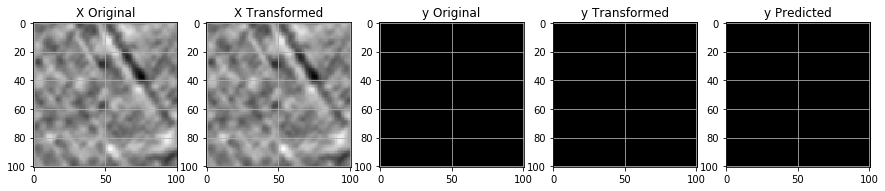

08/09/2018 15:18:49 - SaltNet - INFO - train Mean IOU: 0.5750, Mean Acc: 0.9685, Best Val IOU: 0.2500 at epoch 15
08/09/2018 15:18:52 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.3873, Best Val IOU: 0.2500 at epoch 15
08/09/2018 15:18:52 - SaltNet - INFO - Epoch 16/100
08/09/2018 15:18:52 - SaltNet - INFO - --------------------
08/09/2018 15:19:02 - SaltNet - INFO - Batch Loss: 0.0994, Epoch loss_1: 0.0994, Epoch loss_2: 0.0000, Batch IOU: 0.7000, Batch Acc: 0.9842 at iter 32, epoch 16, Time: 3m 39s


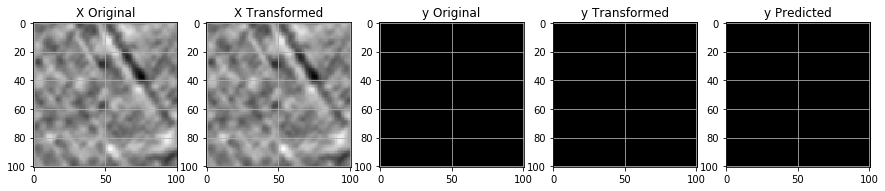

08/09/2018 15:19:02 - SaltNet - INFO - train Mean IOU: 0.6000, Mean Acc: 0.9730, Best Val IOU: 0.2500 at epoch 16
08/09/2018 15:19:05 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.3873, Best Val IOU: 0.2500 at epoch 16
08/09/2018 15:19:05 - SaltNet - INFO - Epoch 17/100
08/09/2018 15:19:05 - SaltNet - INFO - --------------------
08/09/2018 15:19:14 - SaltNet - INFO - Batch Loss: 0.0836, Epoch loss_1: 0.0836, Epoch loss_2: 0.0000, Batch IOU: 0.7000, Batch Acc: 0.9865 at iter 34, epoch 17, Time: 3m 52s


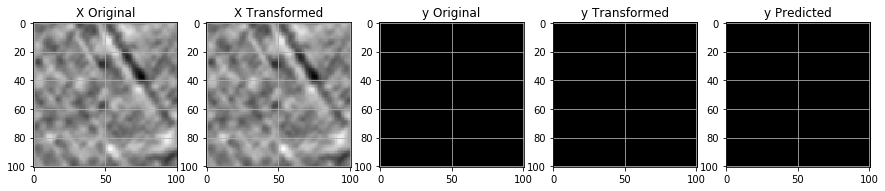

08/09/2018 15:19:15 - SaltNet - INFO - train Mean IOU: 0.6000, Mean Acc: 0.9765, Best Val IOU: 0.2500 at epoch 17
08/09/2018 15:19:17 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.3873, Best Val IOU: 0.2500 at epoch 17
08/09/2018 15:19:17 - SaltNet - INFO - Epoch 18/100
08/09/2018 15:19:17 - SaltNet - INFO - --------------------
08/09/2018 15:19:27 - SaltNet - INFO - Batch Loss: 0.0664, Epoch loss_1: 0.0664, Epoch loss_2: 0.0000, Batch IOU: 0.7000, Batch Acc: 0.9875 at iter 36, epoch 18, Time: 4m 5s


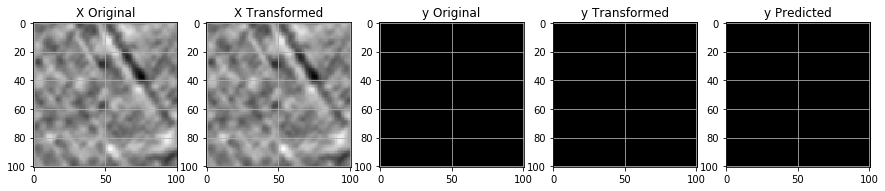

08/09/2018 15:19:28 - SaltNet - INFO - train Mean IOU: 0.6250, Mean Acc: 0.9797, Best Val IOU: 0.2500 at epoch 18
08/09/2018 15:19:30 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.3873, Best Val IOU: 0.2500 at epoch 18
08/09/2018 15:19:30 - SaltNet - INFO - Epoch 19/100
08/09/2018 15:19:30 - SaltNet - INFO - --------------------
08/09/2018 15:19:41 - SaltNet - INFO - Batch Loss: 0.0595, Epoch loss_1: 0.0595, Epoch loss_2: 0.0000, Batch IOU: 0.9500, Batch Acc: 0.9892 at iter 38, epoch 19, Time: 4m 19s


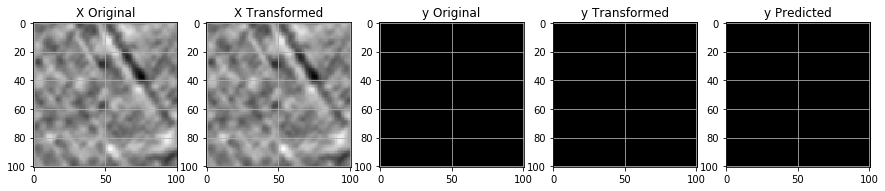

08/09/2018 15:19:42 - SaltNet - INFO - train Mean IOU: 0.7625, Mean Acc: 0.9810, Best Val IOU: 0.2500 at epoch 19
08/09/2018 15:19:45 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.3881, Best Val IOU: 0.2500 at epoch 19
08/09/2018 15:19:45 - SaltNet - INFO - Epoch 20/100
08/09/2018 15:19:45 - SaltNet - INFO - --------------------
08/09/2018 15:19:55 - SaltNet - INFO - Batch Loss: 0.0559, Epoch loss_1: 0.0559, Epoch loss_2: 0.0000, Batch IOU: 0.9750, Batch Acc: 0.9913 at iter 40, epoch 20, Time: 4m 33s


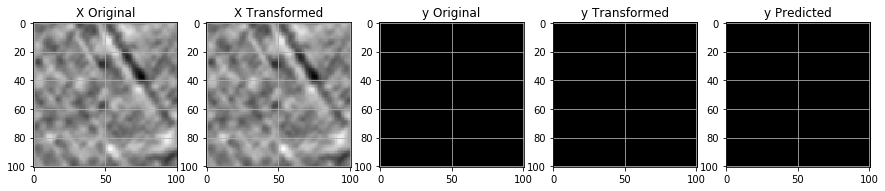

08/09/2018 15:19:56 - SaltNet - INFO - train Mean IOU: 0.7750, Mean Acc: 0.9821, Best Val IOU: 0.2500 at epoch 20
08/09/2018 15:19:59 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.3887, Best Val IOU: 0.2500 at epoch 20
08/09/2018 15:19:59 - SaltNet - INFO - Epoch 21/100
08/09/2018 15:19:59 - SaltNet - INFO - --------------------
08/09/2018 15:20:08 - SaltNet - INFO - Batch Loss: 0.0515, Epoch loss_1: 0.0515, Epoch loss_2: 0.0000, Batch IOU: 0.9750, Batch Acc: 0.9929 at iter 42, epoch 21, Time: 4m 46s


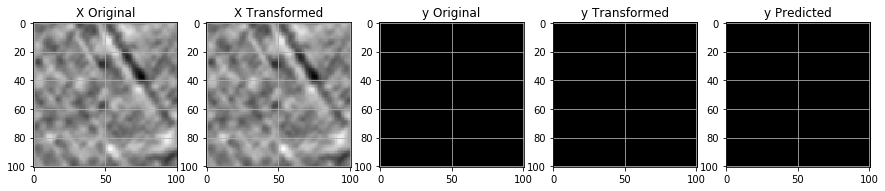

08/09/2018 15:20:09 - SaltNet - INFO - train Mean IOU: 0.7875, Mean Acc: 0.9838, Best Val IOU: 0.2500 at epoch 21
08/09/2018 15:20:11 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.3891, Best Val IOU: 0.2500 at epoch 21
08/09/2018 15:20:11 - SaltNet - INFO - Epoch 22/100
08/09/2018 15:20:11 - SaltNet - INFO - --------------------
08/09/2018 15:20:21 - SaltNet - INFO - Batch Loss: 0.0488, Epoch loss_1: 0.0488, Epoch loss_2: 0.0000, Batch IOU: 0.9750, Batch Acc: 0.9928 at iter 44, epoch 22, Time: 4m 58s


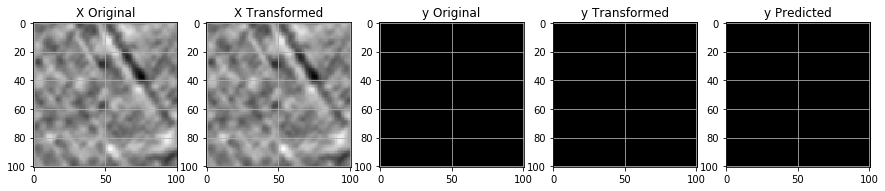

08/09/2018 15:20:21 - SaltNet - INFO - train Mean IOU: 0.7875, Mean Acc: 0.9838, Best Val IOU: 0.2500 at epoch 22
08/09/2018 15:20:24 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.3861, Best Val IOU: 0.2500 at epoch 22
08/09/2018 15:20:24 - SaltNet - INFO - Epoch 23/100
08/09/2018 15:20:24 - SaltNet - INFO - --------------------
08/09/2018 15:20:34 - SaltNet - INFO - Batch Loss: 0.0468, Epoch loss_1: 0.0468, Epoch loss_2: 0.0000, Batch IOU: 0.9750, Batch Acc: 0.9933 at iter 46, epoch 23, Time: 5m 11s


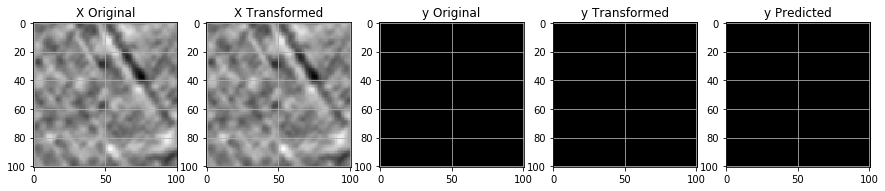

08/09/2018 15:20:35 - SaltNet - INFO - train Mean IOU: 0.7875, Mean Acc: 0.9842, Best Val IOU: 0.2500 at epoch 23
08/09/2018 15:20:37 - SaltNet - INFO - val Mean IOU: 0.2250, Mean Acc: 0.3782, Best Val IOU: 0.2500 at epoch 23
08/09/2018 15:20:37 - SaltNet - INFO - Epoch 24/100
08/09/2018 15:20:37 - SaltNet - INFO - --------------------
08/09/2018 15:20:47 - SaltNet - INFO - Batch Loss: 0.0438, Epoch loss_1: 0.0438, Epoch loss_2: 0.0000, Batch IOU: 0.9750, Batch Acc: 0.9939 at iter 48, epoch 24, Time: 5m 25s


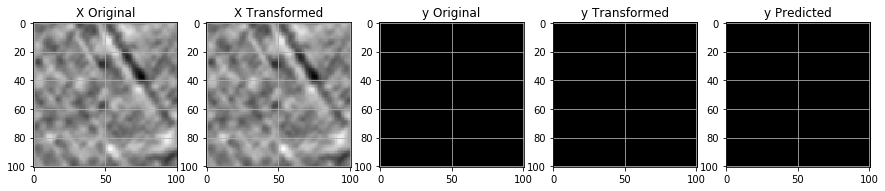

08/09/2018 15:20:48 - SaltNet - INFO - train Mean IOU: 0.8000, Mean Acc: 0.9853, Best Val IOU: 0.2500 at epoch 24
08/09/2018 15:20:51 - SaltNet - INFO - val Mean IOU: 0.2125, Mean Acc: 0.3905, Best Val IOU: 0.2500 at epoch 24
08/09/2018 15:20:51 - SaltNet - INFO - Epoch 25/100
08/09/2018 15:20:51 - SaltNet - INFO - --------------------
08/09/2018 15:21:01 - SaltNet - INFO - Batch Loss: 0.0414, Epoch loss_1: 0.0414, Epoch loss_2: 0.0000, Batch IOU: 0.9750, Batch Acc: 0.9942 at iter 50, epoch 25, Time: 5m 39s


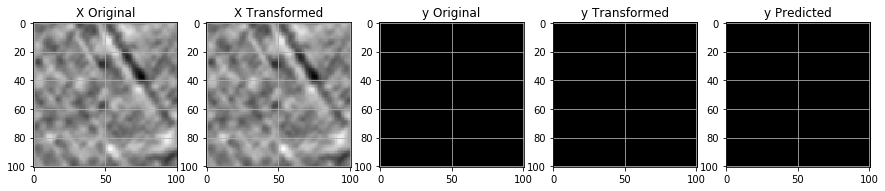

08/09/2018 15:21:02 - SaltNet - INFO - train Mean IOU: 0.8000, Mean Acc: 0.9849, Best Val IOU: 0.2500 at epoch 25
08/09/2018 15:21:05 - SaltNet - INFO - val Mean IOU: 0.2125, Mean Acc: 0.4391, Best Val IOU: 0.2500 at epoch 25
08/09/2018 15:21:05 - SaltNet - INFO - Epoch 26/100
08/09/2018 15:21:05 - SaltNet - INFO - --------------------
08/09/2018 15:21:15 - SaltNet - INFO - Batch Loss: 0.0397, Epoch loss_1: 0.0397, Epoch loss_2: 0.0000, Batch IOU: 0.9750, Batch Acc: 0.9946 at iter 52, epoch 26, Time: 5m 53s


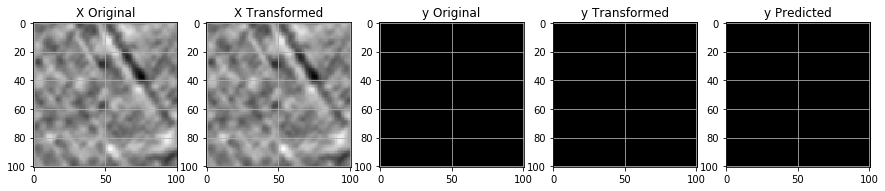

08/09/2018 15:21:16 - SaltNet - INFO - train Mean IOU: 0.7875, Mean Acc: 0.9848, Best Val IOU: 0.2500 at epoch 26
08/09/2018 15:21:19 - SaltNet - INFO - val Mean IOU: 0.1875, Mean Acc: 0.4913, Best Val IOU: 0.2500 at epoch 26
08/09/2018 15:21:19 - SaltNet - INFO - Epoch 27/100
08/09/2018 15:21:19 - SaltNet - INFO - --------------------
08/09/2018 15:21:29 - SaltNet - INFO - Batch Loss: 0.0378, Epoch loss_1: 0.0378, Epoch loss_2: 0.0000, Batch IOU: 1.0000, Batch Acc: 0.9952 at iter 54, epoch 27, Time: 6m 7s


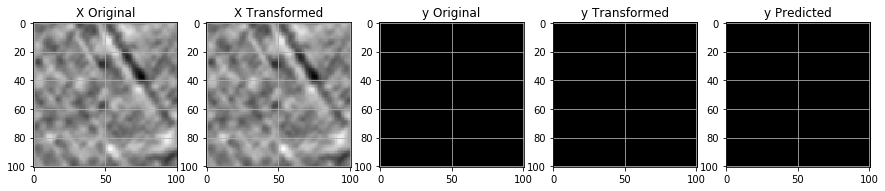

08/09/2018 15:21:30 - SaltNet - INFO - train Mean IOU: 0.8000, Mean Acc: 0.9851, Best Val IOU: 0.2500 at epoch 27
08/09/2018 15:21:33 - SaltNet - INFO - val Mean IOU: 0.1250, Mean Acc: 0.5173, Best Val IOU: 0.2500 at epoch 27
08/09/2018 15:21:33 - SaltNet - INFO - Epoch 28/100
08/09/2018 15:21:33 - SaltNet - INFO - --------------------
08/09/2018 15:21:44 - SaltNet - INFO - Batch Loss: 0.0363, Epoch loss_1: 0.0363, Epoch loss_2: 0.0000, Batch IOU: 1.0000, Batch Acc: 0.9955 at iter 56, epoch 28, Time: 6m 21s


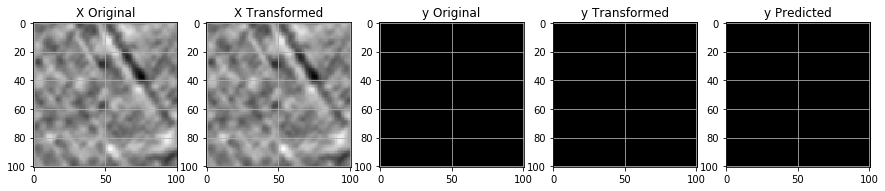

08/09/2018 15:21:45 - SaltNet - INFO - train Mean IOU: 0.8000, Mean Acc: 0.9855, Best Val IOU: 0.2500 at epoch 28
08/09/2018 15:21:48 - SaltNet - INFO - val Mean IOU: 0.0875, Mean Acc: 0.5226, Best Val IOU: 0.2500 at epoch 28
08/09/2018 15:21:48 - SaltNet - INFO - Epoch 29/100
08/09/2018 15:21:48 - SaltNet - INFO - --------------------
08/09/2018 15:22:02 - SaltNet - INFO - Batch Loss: 0.0351, Epoch loss_1: 0.0351, Epoch loss_2: 0.0000, Batch IOU: 1.0000, Batch Acc: 0.9957 at iter 58, epoch 29, Time: 6m 40s


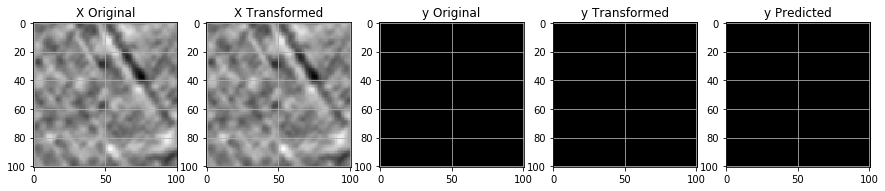

08/09/2018 15:22:04 - SaltNet - INFO - train Mean IOU: 0.8125, Mean Acc: 0.9864, Best Val IOU: 0.2500 at epoch 29
08/09/2018 15:22:09 - SaltNet - INFO - val Mean IOU: 0.0750, Mean Acc: 0.5365, Best Val IOU: 0.2500 at epoch 29
08/09/2018 15:22:09 - SaltNet - INFO - Epoch 30/100
08/09/2018 15:22:09 - SaltNet - INFO - --------------------
08/09/2018 15:22:22 - SaltNet - INFO - Batch Loss: 0.0336, Epoch loss_1: 0.0336, Epoch loss_2: 0.0000, Batch IOU: 1.0000, Batch Acc: 0.9959 at iter 60, epoch 30, Time: 7m 0s


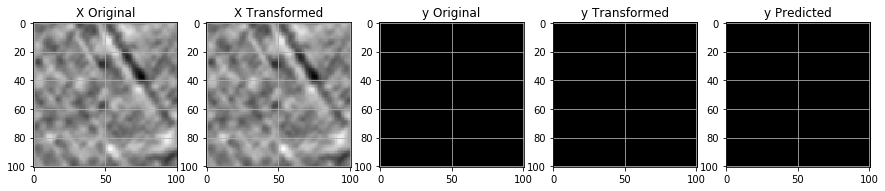

08/09/2018 15:22:23 - SaltNet - INFO - train Mean IOU: 0.8125, Mean Acc: 0.9875, Best Val IOU: 0.2500 at epoch 30
08/09/2018 15:22:28 - SaltNet - INFO - val Mean IOU: 0.1625, Mean Acc: 0.5559, Best Val IOU: 0.2500 at epoch 30
08/09/2018 15:22:28 - SaltNet - INFO - Epoch 31/100
08/09/2018 15:22:28 - SaltNet - INFO - --------------------
08/09/2018 15:22:58 - SaltNet - INFO - Batch Loss: 0.0322, Epoch loss_1: 0.0322, Epoch loss_2: 0.0000, Batch IOU: 1.0000, Batch Acc: 0.9960 at iter 62, epoch 31, Time: 7m 36s


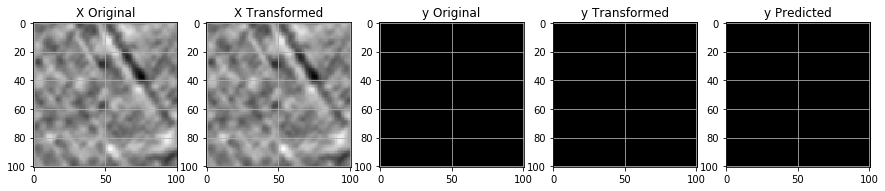

08/09/2018 15:22:59 - SaltNet - INFO - train Mean IOU: 0.8250, Mean Acc: 0.9887, Best Val IOU: 0.2500 at epoch 31
08/09/2018 15:23:04 - SaltNet - INFO - val Mean IOU: 0.1500, Mean Acc: 0.5924, Best Val IOU: 0.2500 at epoch 31
08/09/2018 15:23:04 - SaltNet - INFO - Epoch 32/100
08/09/2018 15:23:04 - SaltNet - INFO - --------------------
08/09/2018 15:23:23 - SaltNet - INFO - Batch Loss: 0.0311, Epoch loss_1: 0.0311, Epoch loss_2: 0.0000, Batch IOU: 1.0000, Batch Acc: 0.9960 at iter 64, epoch 32, Time: 8m 1s


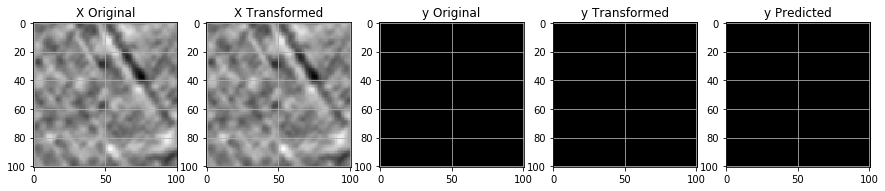

08/09/2018 15:23:25 - SaltNet - INFO - train Mean IOU: 0.8250, Mean Acc: 0.9895, Best Val IOU: 0.2500 at epoch 32
08/09/2018 15:23:29 - SaltNet - INFO - val Mean IOU: 0.1625, Mean Acc: 0.6429, Best Val IOU: 0.2500 at epoch 32
08/09/2018 15:23:30 - SaltNet - INFO - Epoch 33/100
08/09/2018 15:23:30 - SaltNet - INFO - --------------------
08/09/2018 15:23:44 - SaltNet - INFO - Batch Loss: 0.0299, Epoch loss_1: 0.0299, Epoch loss_2: 0.0000, Batch IOU: 1.0000, Batch Acc: 0.9962 at iter 66, epoch 33, Time: 8m 22s


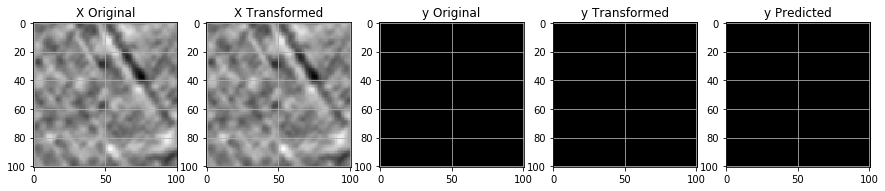

08/09/2018 15:23:45 - SaltNet - INFO - train Mean IOU: 0.8375, Mean Acc: 0.9898, Best Val IOU: 0.2500 at epoch 33


In [ ]:
#saltnet = resnet34unet(in_ch=3, bilinear=False, pretrained=False)

loss_fn_bce = nn.BCEWithLogitsLoss()
loss_lovasz_hinge = LovaszHingeLoss()

optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

model_save_name = None

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=100, print_every=2, save_model_every=None, save_log_every=None, log=log)

## Train the full with full dataset

In [58]:
log.info('New architecture using resnet34 and deeplab v3+.')

07/09/2018 14:21:24 - SaltNet - INFO - New architecture using resnet34 and deeplab v3+.


In [ ]:
model_info = '''
## Train a new model
saltnet = resnet34unet()
loss_fn_bce = nn.BCEWithLogitsLoss()
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)

model_save_name = f'../salt_net/Unet_bce_loss_lovasz_loss_res34{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=250, print_every=50, save_model_every=20, save_log_every=2, log=log, loss2_weight=0.5)
'''

In [70]:
log.info(model_info)

07/09/2018 14:27:19 - SaltNet - INFO - 
## Train a new model
saltnet = resnet34unet()
loss_fn_bce = nn.BCEWithLogitsLoss()
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)

model_save_name = f'../salt_net/Unet_bce_loss_lovasz_loss_res34{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=250, print_every=50, save_model_every=20, save_log_every=2, log=log, loss2_weight=0.5)



In [ ]:
## Train a new model
saltnet = resnet34unet()
loss_fn_bce = nn.BCEWithLogitsLoss()
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)

model_save_name = f'../salt_net/Unet_bce_loss_lovasz_loss_res34_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=250, print_every=50, save_model_every=20, save_log_every=2, log=log, loss2_weight=0.5)

## Load Trained Model

In [ ]:
loaded_model = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True)

Using bilinear for upsampling
Using bilinear for upsampling
Using bilinear for upsampling
Using bilinear for upsampling


In [ ]:
ls

logs/
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-1-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-2-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-3-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-4-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-5-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-1-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-2-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-3-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-4-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-5-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-1-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-2-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-3-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-4-Of-5
Unet_bce_loss_bilin

In [ ]:
model_file_suffix = "Unet_bce_loss_lovasz_loss_finetune_2018_09_06_11_59_40.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
loaded_model.load_state_dict(model_state_dict['model'])

### Make Predictions on validation set

### Set model to evaluation mode

In [ ]:
loaded_model.eval()
assert loaded_model.training == False

In [ ]:
val_dataLoader = DataLoader(SaltDataset(X_val, y_val, depth_val, X_train_mean_img, out_size=128), batch_size=16)

In [ ]:
if torch.cuda.is_available():
    loaded_model.cuda()

In [ ]:
y_val_pred = []

with torch.no_grad():
    for X_val_batch, y_val_batch, depth_val_batch, X_val_id_batch in val_dataLoader:
        y_val_pred.append(loaded_model(X_val_batch))
y_val_pred = torch.cat(y_val_pred)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [ ]:
train_dataLoader = DataLoader(SaltDataset(X_train, y_train, depth_train, X_train_mean_img, out_size=128), batch_size=16)
y_train_pred = []

with torch.no_grad():
    for X_train_batch, y_train_batch, depth_train_batch, X_train_id_batch in train_dataLoader:
        y_train_pred.append(loaded_model(X_train_batch))
y_train_pred = torch.cat(y_train_pred)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


Image ID: 797


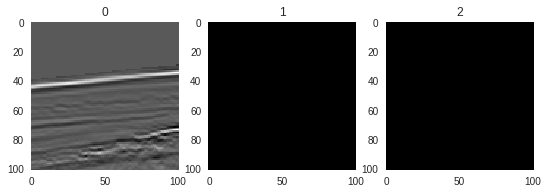

Image ID: 794


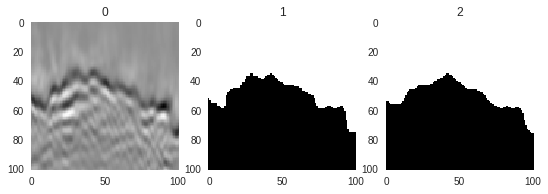

Image ID: 787


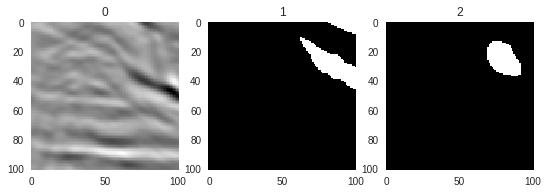

Image ID: 797


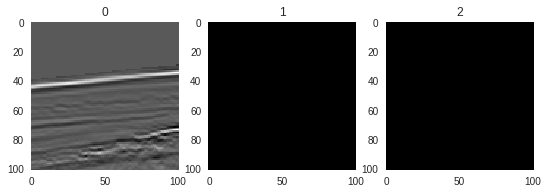

Image ID: 789


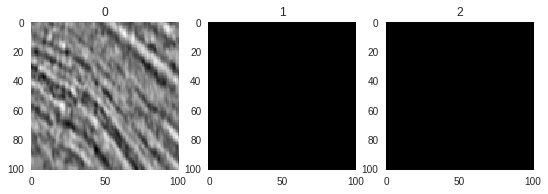

Image ID: 796


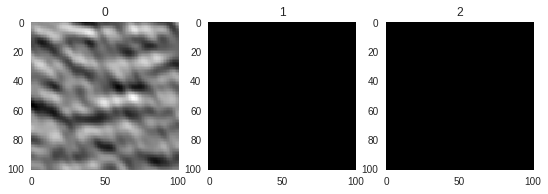

Image ID: 796


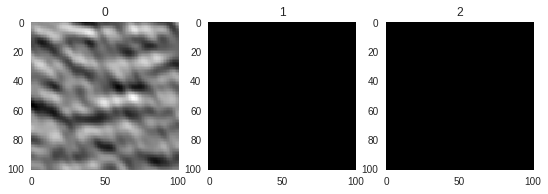

Image ID: 789


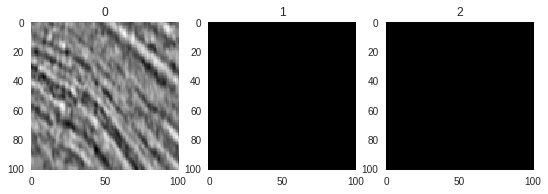

Image ID: 796


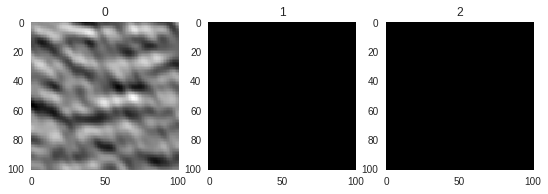

Image ID: 784


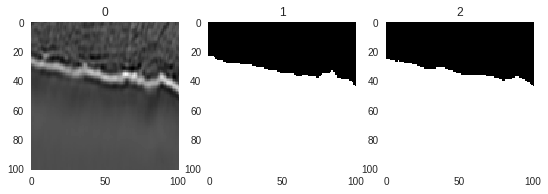

In [ ]:
for i in range(10):
    rand_id = np.random.choice(X_val_id_batch)
    print(f'Image ID: {rand_id}')
    val_img = X_val[rand_id]/255
    val_mask = y_val[rand_id]
    val_mask_pred = y_val_pred.ge(MASK_CUTOFF)[rand_id]
    plot_img_mask_pred([val_img, val_mask, val_mask_pred], range(3), img_per_line=3)

Image ID: 3199


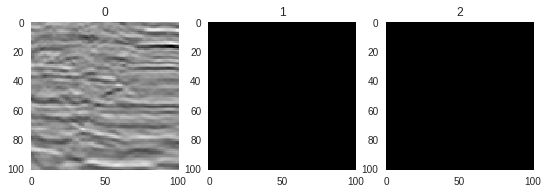

Image ID: 3192


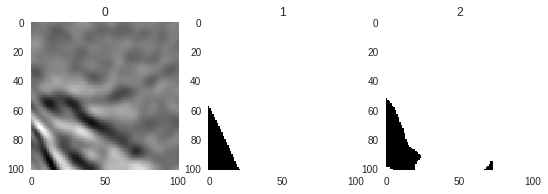

Image ID: 3185


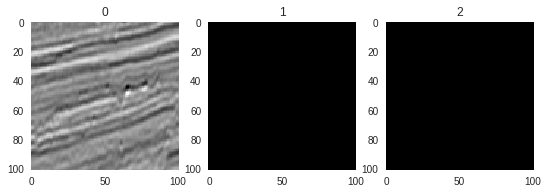

Image ID: 3192


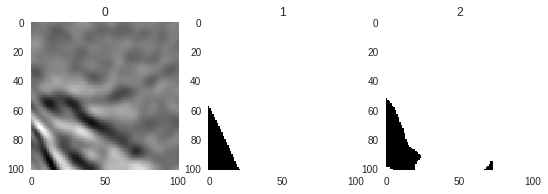

Image ID: 3188


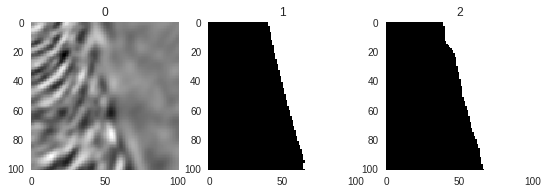

Image ID: 3193


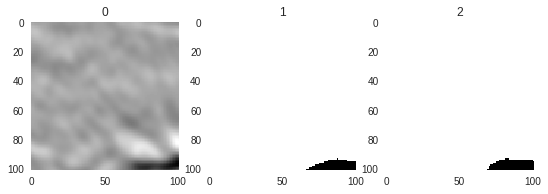

Image ID: 3192


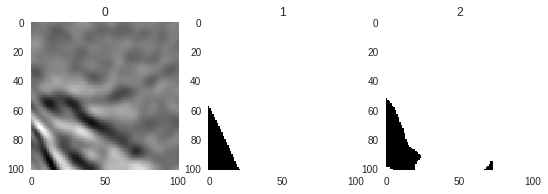

Image ID: 3192


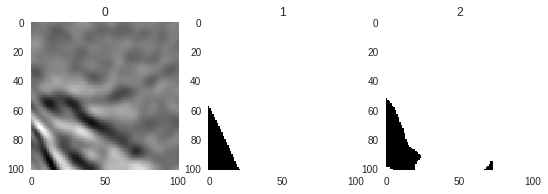

Image ID: 3188


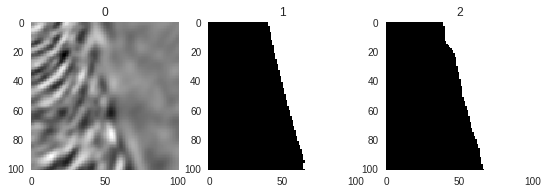

Image ID: 3192


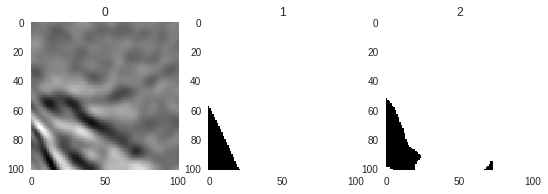

In [ ]:
for i in range(10):
    rand_id = np.random.choice(X_train_id_batch)
    print(f'Image ID: {rand_id}')
    img = X_train[rand_id]/255
    mask = y_train[rand_id]
    mask_pred = y_train_pred.ge(MASK_CUTOFF)[rand_id]
    plot_img_mask_pred([img, mask, mask_pred], range(3), img_per_line=3)

In [ ]:
ZERO_MASK_CUTOFF = 20
MASK_CUTOFF = 0.

In [ ]:
y_val_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_val, y_val_pred.gt(MASK_CUTOFF), y_val.squeeze())

06/09/2018 05:32:56 - SaltNet - INFO - IOU score before: 0.8192499999999999, IOU Score after:0.81825


In [ ]:
y_val_pred_adj = adjust_predictions(0, X_val, y_val_pred.gt(-0.3), y_val.squeeze())

06/09/2018 06:52:24 - SaltNet - INFO - IOU score before: 0.8194999999999999, IOU Score after:0.8194999999999999


In [ ]:
results=[]
for cut_off in range(0, 300, 10):
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(cut_off, X_val, y_val_pred.gt(MASK_CUTOFF), y_val.squeeze()), y_val.squeeze()))

In [ ]:
range(0, 300, 10)[np.argmax(results)]

0

In [ ]:
results

In [ ]:
y_val_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_val, y_val_pred.gt(MASK_CUTOFF), y_val.squeeze())

06/09/2018 05:33:54 - SaltNet - INFO - IOU score before: 0.8192499999999999, IOU Score after:0.81825


In [ ]:
y_train_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_train, y_train_pred.gt(MASK_CUTOFF), y_train.squeeze())

06/09/2018 05:34:01 - SaltNet - INFO - IOU score before: 0.8289687499999999, IOU Score after:0.8294687500000001


In [ ]:
results=[]
for cut_off in range(0, 300, 10):
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(cut_off, X_train, y_train_pred.gt(MASK_CUTOFF), y_train.squeeze()), y_train.squeeze()))

In [ ]:
range(0, 3000, 10)[np.argmax(results)]

20

## Make predictions on test set

In [ ]:
#test_dataLoader = DataLoader(SaltDataset(np_test[:10], None, depth_test, X_train_mean_img), batch_size=4)
test_dataLoader = DataLoader(SaltDataset(X_test, np.zeros_like(X_test), depth_test, X_train_mean_img, out_size=128), batch_size=16)

In [ ]:
y_test_pred_raw = []
with torch.no_grad():
    for X_test_batch, y_test_batch, depth_test_batch, X_test_id_batch in test_dataLoader:
        y_test_pred_raw.append(loaded_model(X_test_batch))
y_test_pred = torch.cat(y_test_pred_raw)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


### Show segmentation masks for a few images

In [ ]:
for i in range(10):
    rand_id = np.random.choice(X_test_id_batch)
    print(f'Image ID: {rand_id}')
    img = X_test[rand_id]/255
    mask_pred = y_test_pred.ge(0.5)[rand_id]
    plot_img_mask_pred([img, mask_pred], range(2))

### Adjust predictions

In [ ]:
 ZERO_MASK_CUTOFF = 0.

In [ ]:
y_test_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_test, y_test_pred.gt(MASK_CUTOFF))

### Encode predictions using RLE(Run Length Encoding) method

In [ ]:
y_test_pred_rle = rle_encoder3d(y_test_pred_adj)

In [ ]:
y_test_pred_adj.shape

(18000, 101, 101)

In [ ]:
df_test_rle = pd.DataFrame(index=misc_data['np_test_ids'], data=y_test_pred_rle).reset_index()

In [ ]:
df_test_rle.columns = ['id', 'rle_mask']

In [ ]:
df_test_rle[df_test_rle.rle_mask==''].shape

(7807, 2)

In [ ]:
df_test_rle.shape

(18000, 2)

In [ ]:
df_test_rle.to_csv(f'submission_{get_current_time_as_fname()}.csv', index=False)

In [ ]:
ls

logs/
submission_2018_09_06_16_20_54.csv
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-1-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-2-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-3-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-4-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-5-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-1-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-2-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-3-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-4-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-5-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-1-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-2-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-3-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.c

In [ ]:
from google.colab import files


In [ ]:
files.download('submission_2018_09_06_16_20_54.csv') 

In [ ]:
y_pred_adj = adjust_predictions(0, X_val, y_val_pred.gt(MASK_CUTOFF))

In [ ]:
df_test_rle = pd.DataFrame(depth_val, columns=['z'])

In [ ]:
df_test_rle['num_salt_pix'] = y_pred_adj.sum((1,2))

In [ ]:
df_test_rle.head()

,z,num_salt_pix
id,,
25db231ea0,581,3773
dfd3138198,373,0
2425501bf4,788,0
fbb8eba26d,743,0
bea9b0571b,366,9422


In [ ]:
exp_black_mask_pct = [0.822, 0.755, 0.707, 0.568, 0.464, 0.378, 0.289, 0.285, 0.317, 0.25, 0.354, 0.255, 0.339, 0.357, 0.385, 0.442, 0.65, 0.58, 0.778]

In [ ]:
df_test_z_grp

,total,black_mask,black_mask_pct
z_bin,,,
50,16.0,15.0,0.937500
100,31.0,21.0,0.677419
150,28.0,24.0,0.857143
200,47.0,28.0,0.595745
250,34.0,17.0,0.500000
300,45.0,15.0,0.333333
350,55.0,21.0,0.381818
400,48.0,20.0,0.416667
450,75.0,26.0,0.346667


In [ ]:
len(exp_black_mask_pct)

19

In [ ]:
df_test_rle['z_bin'] = df_test_rle.z.floordiv(50).mul(50)
df_test_rle['black_mask'] = df_test_rle.num_salt_pix==0
df_test_z_grp = (
    df_test_rle.groupby('z_bin')
    .apply(lambda x: pd.Series([len(x),
                               x.black_mask.sum(),
                               x.black_mask.sum()/len(x)],
                               ['total','black_mask', 'black_mask_pct'])
          )
    #.sort_values('black_mask_pct', ascending=False)
)
df_test_z_grp['exp_black_mask_pct'] = exp_black_mask_pct[:-1]

In [ ]:
df_test_rle.head()

,z,num_salt_pix,z_bin,black_mask
id,,,,
25db231ea0,581,3773,550,False
dfd3138198,373,0,350,True
2425501bf4,788,0,750,True
fbb8eba26d,743,0,700,True
bea9b0571b,366,9422,350,False


In [ ]:
df_test_z_grp

,total,black_mask,black_mask_pct,exp_black_mask_pct
z_bin,,,,
50,16.0,15.0,0.937500,0.822
100,31.0,21.0,0.677419,0.755
150,28.0,24.0,0.857143,0.707
200,47.0,28.0,0.595745,0.568
250,34.0,17.0,0.500000,0.464
300,45.0,15.0,0.333333,0.378
350,55.0,21.0,0.381818,0.289
400,48.0,20.0,0.416667,0.285
450,75.0,26.0,0.346667,0.317
